In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

## Questions:
1) How far in advance can your model reliably predict demand, and how does accuracy change the further out you forecast? <br>
2) What specific business decisions can we confidently make using the Random Forest model, and where should we remain cautious? <br>
3) How does the model account for cancellations, and are those predictions reliable enough for staffing decisions? <br>
4) How can we include future marketing campaigns or major events into the forecast if they aren’t in the historical data? <br>
5) Can the model be retrained on a monthly or quarterly basis to capture recent trends? <br>
6) If the Random Forest model performs best, how do you suggest we communicate insights to frontline managers who need transparency and clear reasoning? <br>
7) Have you stress-tested the model using 2020-style “shock” scenarios (e.g., sudden drop or spike in demand)? <br>
8) What would it take to build a profit/cost-optimized model that accounts for overstaffing and understaffing trade-offs? <br>
9) Can this model be adapted or scaled across different hotel locations or brands with different guest profiles or seasonality? <br>
10) What are the top 3 improvements or additional data sources (e.g., weather, flight data, pricing trends) you’d recommend to boost model performance? <br>


### Data Understanding

In [367]:
df = pd.read_csv('hotel_bookings.csv')

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [369]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016-08-28 16:39:45.727447808
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2015-07-01 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016-03-13 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016-09-06 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017-03-18 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017-08-31 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,NaN


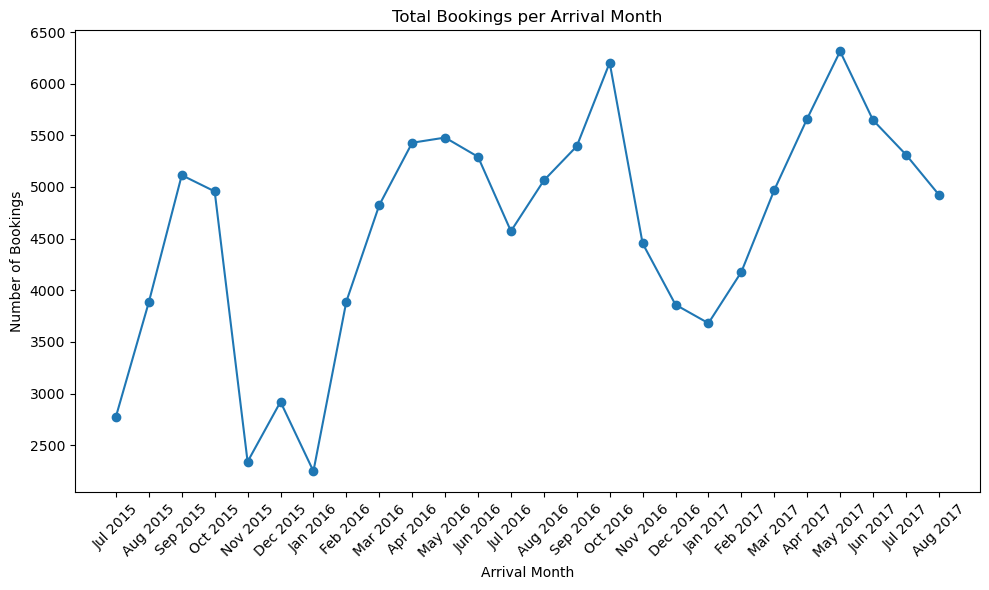

In [373]:
#PLOT DATA
def plot_bookings_by_month(df):
    df = df.copy()
    df['arrival_month'] = df['arrival_month'].astype(str)

    # Group by month and sum bookings
    monthly_grouped = df.groupby('arrival_month')['num_bookings'].sum().reset_index()

    # Try to sort the months chronologically if possible
    try:
        monthly_grouped['arrival_month'] = pd.to_datetime(monthly_grouped['arrival_month'])
        monthly_grouped = monthly_grouped.sort_values('arrival_month')
        x_labels = monthly_grouped['arrival_month'].dt.strftime('%b %Y')  # Format like 'Jan 2024'
    except:
        x_labels = monthly_grouped['arrival_month']

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, monthly_grouped['num_bookings'], marker='o')
    plt.title('Total Bookings per Arrival Month')
    plt.xlabel('Arrival Month')
    plt.ylabel('Number of Bookings')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
plot_bookings_by_month(monthly_data)

### Data Preparation

What I do here is create a datetime, then group data at the monthly level to prepare for forecasting. Finally I create two df's, one that is just the grouped by version and then a second that includes dummies.

In [99]:


#Step 1)
#This funciton creates two new dataframes that has data grouped monthly. 
#The first df returned has monthly aggregate data
#Thes econd return is monthly aggregate data with dummies for categorical variables
def prep_data(df):
    #Combined year, month and day of month to get a date
    df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + 
                                         df['arrival_date_month'] + '-' + 
                                         df['arrival_date_day_of_month'].astype(str))
    #Get first date of the month and turn to period
    df['arrival_month'] = df['arrival_date'].dt.to_period('M')#.dt.to_timestamp()
    # print(type(df.arrival_month))
    #Group by features I want to use in my model
    monthly_data = df.groupby(['arrival_month','hotel','market_segment','distribution_channel','customer_type']).agg({
        'lead_time': 'mean', #Should I use sum? I should try another model with sum
        #'is_canceled': 'mean',  #Is this a percentage then? In the future we would need to make assumptions on this
        'adults':'mean',
        'children':'mean',
        'babies':'mean',
        'is_repeated_guest':'mean',
        'previous_cancellations':'mean',
        'previous_bookings_not_canceled':'mean'
        #'adr':'mean' We wouldn't know this prior to a reservation
        })
    monthly_data['num_bookings'] = df.groupby(['arrival_month','hotel','market_segment','distribution_channel','customer_type']).size().values
    monthly_data = monthly_data.reset_index() #Finally we have a new df that has the features I would like to use to predict monthly bookings
    monthly_data_dummies = pd.get_dummies(monthly_data, columns=['hotel','market_segment','distribution_channel',
                                                                'customer_type'],
                              drop_first=True)
    
    
    return monthly_data.dropna(subset=['children']), monthly_data_dummies.dropna(subset=['children'])
    
monthly_data, monthly_data_dummies = prep_data(df)

monthly_data_dummies.head()


,arrival_month,lead_time,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,num_bookings,hotel_Resort Hotel,...,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,2015-07,16.200000,1.600000,0.000000,0.0,0.000,0.000,0.0,5,False,...,False,False,False,False,False,True,False,False,True,False
1,2015-07,1.250000,1.000000,0.000000,0.0,0.000,0.000,0.0,4,False,...,False,False,False,True,False,False,False,False,True,False
2,2015-07,25.904762,1.857143,0.190476,0.0,0.000,0.000,0.0,21,False,...,False,False,False,True,False,False,False,False,True,False
3,2015-07,63.000000,2.000000,0.000000,0.0,0.000,0.000,0.0,2,False,...,False,False,False,True,False,False,False,False,False,True
4,2015-07,272.800000,2.000000,0.000000,0.0,0.005,1.005,0.0,200,False,...,False,False,False,False,False,True,False,False,False,False


### Modeling

Here I create a function that runs the models for predicting number of bookings. 

In [330]:
#### Model and Run Data
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def run_modeling_pipeline_no_prophet(df, train_start, train_end, test_start, test_end, top_n_features):
    
    results = {}
    df = df.copy()
    
    # Convert arrival_month to datetime
    df['arrival_month'] = pd.to_datetime(df['arrival_month'].astype(str))

    # Filter training and testing data
    train_df = df[(df['arrival_month'] >= train_start) & (df['arrival_month'] <= train_end)]
    test_df = df[(df['arrival_month'] >= test_start) & (df['arrival_month'] <= test_end)]

    # Separate features and target
    target = 'num_bookings'
    features = df.columns.drop(['arrival_month', target])
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature Selection using Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train)
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print("Top Feature Ranking:\n", feature_importance_df.head(top_n_features))

    selected_features = feature_importance_df.head(top_n_features)['feature'].tolist()
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    # Helper function for evaluation
    def evaluate_model(name, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'FcastAccuracy': np.sum(y_pred)/np.sum(y_true)
        }
        return y_pred

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_sel, y_train)
    lr_pred = evaluate_model("Linear Regression", y_test, lr.predict(X_test_sel))

    # Ridge Regression
    ridge = Ridge()
    ridge.fit(X_train_sel, y_train)
    ridge_pred = evaluate_model("Ridge Regression", y_test, ridge.predict(X_test_sel))

    # Lasso Regression
    lasso = Lasso()
    lasso.fit(X_train_sel, y_train)
    lasso_pred = evaluate_model("Lasso Regression", y_test, lasso.predict(X_test_sel))

    # Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train_sel, y_train)
    rf_pred = evaluate_model("Random Forest", y_test, rf_model.predict(X_test_sel))

    # XGBoost
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train_sel, y_train)
    xgb_pred = evaluate_model("XGBoost", y_test, xgb_model.predict(X_test_sel))

    # Combine actuals and predictions into one DataFrame
    combined_df = pd.DataFrame({
        'arrival_month': test_df['arrival_month'].values,
        'actuals': y_test.values,
        'Linear Regression': lr_pred,
        'Ridge Regression': ridge_pred,
        'Lasso Regression': lasso_pred,
        'Random Forest': rf_pred,
        'XGBoost': xgb_pred
    })

    combined_df = combined_df.groupby('arrival_month').sum()
    results_df = pd.DataFrame(results).T  # .T transposes it so models are rows
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Model'}, inplace=True)

    return results_df, combined_df
    
results, combined_df = run_modeling_pipeline_no_prophet(monthly_data_dummies, '2015-07', '2016-01', '2016-02', '2017-08', 7)

results

#Lasso Appears to forecast the best when using 2015-07 to 2016-01 for training data

combined_df

Top Feature Ranking:
                      feature  importance
3                     babies    0.246438
5     previous_cancellations    0.217308
2                   children    0.170355
4          is_repeated_guest    0.095827
0                  lead_time    0.079576
1                     adults    0.064739
13  market_segment_Online TA    0.026996


,actuals,Linear Regression,Ridge Regression,Lasso Regression,Random Forest,XGBoost
arrival_month,,,,,,
2016-02-01,3891,3154.058605,3172.454759,3258.233188,3004.19,2964.071045
2016-03-01,4824,3872.474118,3894.875682,3995.434784,3076.65,2674.237061
2016-04-01,5428,3955.562893,3972.568979,4059.683102,3556.98,3108.257324
2016-05-01,5478,4330.849742,4340.243618,4403.626999,3662.20,3394.007812
2016-06-01,5292,4042.271612,4072.285766,4204.255579,3518.77,3469.655762
2016-07-01,4572,3635.518257,3679.365112,3787.499668,2538.37,2105.092773
2016-08-01,5063,3997.274609,4017.877105,4081.135308,2936.16,2520.262939
2016-09-01,5394,5464.874454,5469.936408,5490.731415,2154.33,2126.701416
2016-10-01,6203,5766.871326,5769.671640,5796.980376,3579.60,3280.766602


In [119]:
monthly_data.arrival_month.unique()

<PeriodArray>
['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
 '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
 '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
 '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
Length: 26, dtype: period[M]

In [385]:
results, combined_df = run_modeling_pipeline_no_prophet(monthly_data_dummies, '2015-07', '2017-01', '2017-02', '2017-08', 10)

results
# combined_df

Top Feature Ranking:
                            feature  importance
3                           babies    0.496597
2                         children    0.119979
1                           adults    0.106375
13        market_segment_Online TA    0.062753
0                        lead_time    0.052352
5           previous_cancellations    0.051725
4                is_repeated_guest    0.025002
6   previous_bookings_not_canceled    0.024535
20         customer_type_Transient    0.019842
7               hotel_Resort Hotel    0.014251


,Model,MSE,RMSE,R2,FcastAccuracy
0,Linear Regression,76049.506524,275.770750,0.201460,0.770745
1,Ridge Regression,76110.744813,275.881759,0.200817,0.771568
2,Lasso Regression,76658.388711,276.872513,0.195067,0.781973
3,Random Forest,14076.483927,118.644359,0.852193,0.997138
4,XGBoost,20848.140830,144.388853,0.781089,0.906745


#### Thought Process and Pivot to Time Series

After running these models, I realized that it really doesn't make sense to use these models as one would also have to predict the features such as how many adults, babies and children. For example, it doesn't make to say "well we know in 6 months we will have 100 parents, 10 babies and 30 kids". On the other end, it makes more sense to predict how many paretns, kids and babies you will have based on bookings. Since my goal is to predict number of bookings, I am pivoting here to use a time series models to predict bookings. 

In [393]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import itertools
from statsmodels.tsa.stattools import adfuller

# Suppress statsmodels warnings
warnings.filterwarnings("ignore")


def forecast_models(df=None, train_start='2015-07', train_end='2017-06', test_start='2017-07', test_end='2017-08', target='num_bookings'):
    # Default to using ts_df if df not provided
    if df is None:
        df = ts_df.copy()

    df['arrival_month'] = pd.to_datetime(df['arrival_month'].astype(str))
    df = df.set_index('arrival_month').sort_index()
    df.index.freq = 'MS'

    train = df[train_start:train_end]
    test = df[test_start:test_end]

    y_train = train[target]
    y_test = test[target]

    #Check for stationary with Ad Fullter test. If not transformed then can really hurt ARIMA Model
    adf_result = adfuller(y_train)
    is_stationary = adf_result[1] < 0.05

    if not is_stationary:
        y_train_diff = y_train.diff().dropna()
        arima_series = y_train_diff
    else:
        arima_series = y_train

    #Business Cost Evaluation with assumptions
    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        forecast_accuracy = sum(y_pred) / sum(y_true)
        # Cost function: assume $100 overstaff cost, $200 understaff cost per booking error
        cost = sum([(100 if p > a else 200) * abs(p - a) for p, a in zip(y_pred, y_true)])
        return mse, rmse, r2, forecast_accuracy, cost

    #ARIMA Grid search to hyperparameter tune
    best_aic = np.inf
    best_model_arima = None

    for p, d, q in itertools.product(range(2), repeat=3):
        try:
            model = ARIMA(arima_series, order=(p, d, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_model_arima = model
        except:
            continue

    arima_pred = best_model_arima.forecast(steps=len(y_test))
    if not is_stationary:
        arima_pred = y_train.iloc[-1] + arima_pred.cumsum()

    #SARIMA Grid search to hyper parameter tune
    best_aic = np.inf
    best_model_sarima = None

    for p, d, q in itertools.product(range(2), repeat=3):
        for P, D, Q in itertools.product(range(2), repeat=3):
            try:
                model = SARIMAX(arima_series, order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=False)
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_model_sarima = model
            except:
                continue

    sarima_pred = best_model_sarima.forecast(steps=len(y_test))
    if not is_stationary:
        sarima_pred = y_train.iloc[-1] + sarima_pred.cumsum()

    #Prophet Model
    prophet_df = train.reset_index()[['arrival_month', target]]
    prophet_df.columns = ['ds', 'y']
    model_prophet = Prophet()
    model_prophet.fit(prophet_df)

    future = pd.date_range(start=test.index.min(), end=test.index.max(), freq='MS')
    future_df = pd.DataFrame({'ds': future})
    forecast = model_prophet.predict(future_df)
    prophet_pred = forecast['yhat'].values

    #LEt's evaluate the results
    results = {}
    results['ARIMA'] = evaluate(y_test, arima_pred)
    results['SARIMA'] = evaluate(y_test, sarima_pred)
    results['Prophet'] = evaluate(y_test, prophet_pred)

    result_df = pd.DataFrame(results, index=['MSE', 'RMSE', 'R2', 'Forecast_Accuracy', 'Business_Cost']).T

    combined_df = pd.DataFrame({
        'arrival_month': test.index,
        'actuals': y_test.values,
        'arima_pred': arima_pred.values,
        'sarima_pred': sarima_pred.values,
        'prophet_pred': prophet_pred
    })

    return result_df, combined_df



ts_df = monthly_data.groupby('arrival_month').sum()['num_bookings'].reset_index()

ts_results_df, ts_combined_df = forecast_models(ts_df, '2015-07', '2017-01', '2017-02', '2017-08', 'num_bookings')
ts_results_df

19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing


,MSE,RMSE,R2,Forecast_Accuracy,Business_Cost
ARIMA,2.356466e+06,1535.078631,-4.919793,0.733191,1.974704e+06
SARIMA,3.035834e+05,550.984073,0.237353,0.948761,5.796142e+05
Prophet,3.651200e+05,604.251570,0.082765,1.015135,5.129404e+05


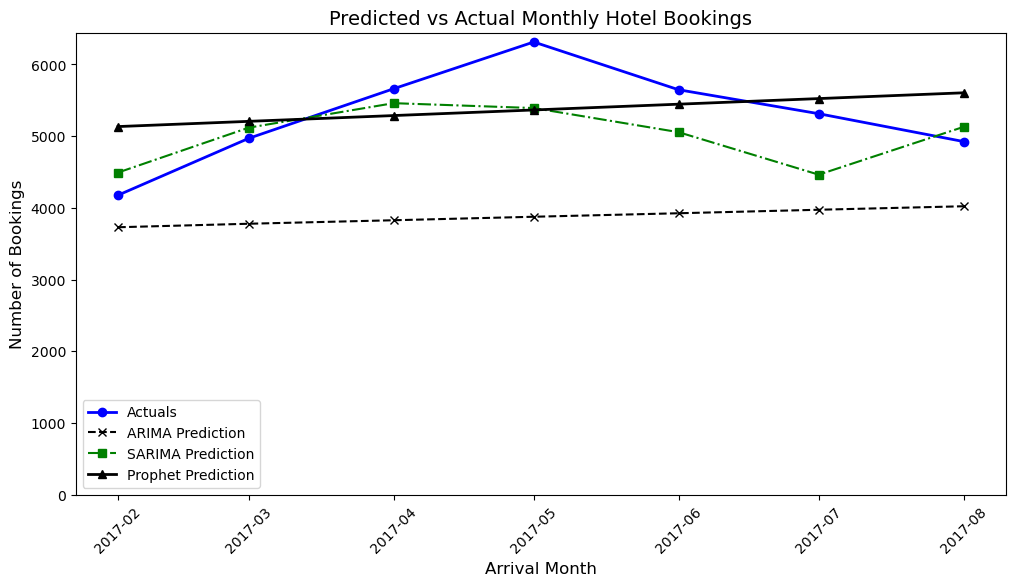

In [425]:
plt.figure(figsize=(12, 6))

# Plot each line on the graph
plt.plot(ts_combined_df['arrival_month'], ts_combined_df['actuals'], label='Actuals', linewidth=2, marker='o', color = 'blue')
plt.plot(ts_combined_df['arrival_month'], ts_combined_df['arima_pred'], label='ARIMA Prediction', linestyle='--', marker='x', color = 'black')
plt.plot(ts_combined_df['arrival_month'], ts_combined_df['sarima_pred'], label='SARIMA Prediction', linestyle='-.', marker='s', color = 'green')
plt.plot(ts_combined_df['arrival_month'], ts_combined_df['prophet_pred'], label='Prophet Prediction',linewidth=2, linestyle='-', marker='^', color = 'black')

# Plot Details
plt.title('Predicted vs Actual Monthly Hotel Bookings', fontsize=14)
plt.xlabel('Arrival Month', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

1) How far in advance can your model reliably predict demand, and how does accuracy change the further out you forecast? <br>

Based on the time series model, we can accurately predict demand about 1 year out using 2 years of data. Within the year, the Prohpet model is fairly accurate as it's using seasonality and trend, forecast accuracy varies by about 5% to 10%. Based on the data set, it's hard to predict how accuracy will change beyond the year when using two years of data. However, when using 1 year of data, accuracy dropped by about 20%. 

2) What specific business decisions can we confidently make using the ARIMA model, and where should we remain cautious? <br>

Given the current data available, I am fairly confident we can make booking forecasts up to 1.5 years out when using the entire data set as a training set for the future as it has about 3 years of historcal data. This assumes that business patterns and trends will remain the same. During that time and especially beyond the 1.5 years, it is very important to gather business assumptions and include them to ensure the model can add noise and patterns that is not present today.

3) How does the model account for cancellations, and are those predictions reliable enough for staffing decisions? <br>

In the current model, it does not count for cancellations, instead, it predicts total bookings that will be scheduled whether they are to be cancelled or not. An additional model, predicting cancellations rate would need to be create so that we can not only forecast bookings, but then forecast bookings that would be succcesful. 

4) How can we include future marketing campaigns or major events into the forecast if they aren’t in the historical data? <br>

Great question! My recommendation here would be to first create the long term forecast using SARIMA. Then, after the model is creating using historical patterns, we manually add and increase/decrease volume at given months and weeks based on our assumptions.

5) Can the model be retrained on a monthly or quarterly basis to capture recent trends? <br>

The model can be retrained monthly or quarterly. Depending how fast we believe our underlying patterns will change will ditcate the cadence. 

6) If the SARIMA model performs best, how do you suggest we communicate insights to frontline managers who need transparency and clear reasoning? <br>

Great question! The recommendation would be to explain how the model takes intou account historical patterns and trends to predict into the future. In addition, assumptions would be added on top of the model to increase accuracy as the model without assumptions only takes into account historical patterns. 

7) Have you stress-tested the model using 2020-style “shock” scenarios (e.g., sudden drop or spike in demand)? <br>

While many different scenarios where used given the historical data set to test model accuracy using different training and testing time sets, the historical data was not manipulated to test different historical scenarios. 

8) What would it take to build a profit/cost-optimized model that accounts for overstaffing and understaffing trade-offs? <br>

To make this happen we would need to gather labor costs and then create calculations from it.

9) Can this model be adapted or scaled across different hotel locations or brands with different guest profiles or seasonality? <br>

Yes, the model can be adapted across differetn hotel locations and brands. When taking account guest profiles, this is particular challenging unless we have clear ways to distinguish customer profiles. In the absene of this data, a model can be created to segment customer profiles using k-means.

10) What are the top 3 improvements or additional data sources (e.g., weather, flight data, pricing trends) you’d recommend to boost model performance? <br>

Additional data sources that would help performance are marketing campaign launches information, marketing spending information website traffic information. 